# Факторный анализ

---

Главными целями **факторного анализа** являются сокращение числа переменных (редукция данных) и определение структуры взаимосвязей между переменными, т.е. классификация переменных. Поэтому факторный анализ используется или как метод сокращения данных, или как метод классификации переменных.

Для начала работы факторного анализа необходимо построить и посмотреть на таблицу корреляций переменных между собой.

In [1]:
import pandas as pd
from scipy.stats import pearsonr

df = pd.read_csv("../data/student_perfomance_sample.csv")

var = ["study_hours_week", "attendance_pct", "prev_exam_score", "final_exam_score"]
corr_matrix = pd.DataFrame(index=var, columns=var, dtype=float)
for i in var:
    for j in var:
        r, p = pearsonr(df[i].dropna(), df[j].dropna())
        corr_matrix.loc[i, j] = r

display(corr_matrix)

,study_hours_week,attendance_pct,prev_exam_score,final_exam_score
study_hours_week,1.000000,-0.006658,0.027731,0.462632
attendance_pct,-0.006658,1.000000,-0.020128,0.604737
prev_exam_score,0.027731,-0.020128,1.000000,0.152750
final_exam_score,0.462632,0.604737,0.152750,1.000000


Из таблицы видно, что переменная *Итоговый балл* умеренно коррелирует с переменными *Часы учебы/нед* и *Процент посещения*, а с переменными *Результат предыдущего экзамена* слабо, но ближе к умеренной взаимосвязи. Остальные переменные коррелируют слабо.

Теперь необходимо понять, сколько факторов нужно использовать. Для этого сначала выставим максимум факторов, равный количеству используемых переменных, то есть 4 и минимальное собственное значение = 0. Далее построим таблицу собственных значений.

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

vars_used = ["study_hours_week", "attendance_pct", "prev_exam_score", "final_exam_score"]
X = df[vars_used].dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=4)
pca.fit(X_scaled)
eigenvalues = pca.explained_variance_
explained_var = pca.explained_variance_ratio_ * 100
cumulative = explained_var.cumsum()
pca_table = pd.DataFrame({"Собственное значение": eigenvalues, "% общей дисперсии": explained_var, "Кумулятивная дисперсия": cumulative}, index=[1, 2, 3, 4])
display(pca_table.style.format("{:.4f}"))

,Собственное значение,% общей дисперсии,Кумулятивная дисперсия
1,1.7756,44.3419,44.3419
2,1.0381,25.9257,70.2677
3,0.9698,24.2203,94.4880
4,0.2207,5.5120,100.0000


Второй столбец отвечает за процент объяснённой общей дисперсии, а третий столбец содержит накопленную или кумулятивную дисперсию. В соответствии с критерием Кайзера можно выделить два фактора. Построим график каменистой осыпи (рисунок ниже):

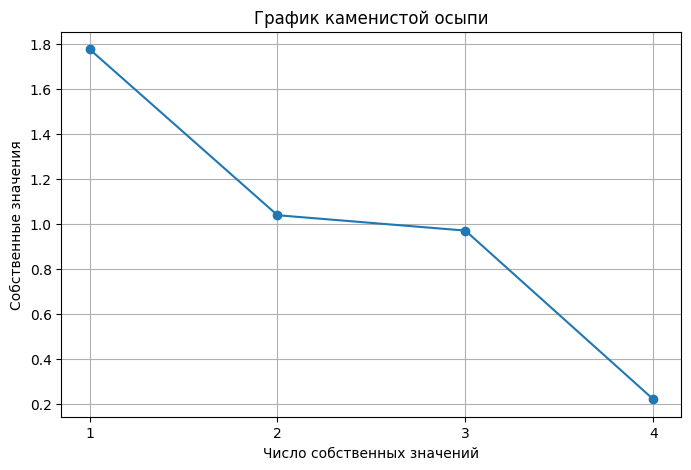

In [3]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8,5))
plt.plot(range(1, len(eigenvalues)+1), eigenvalues, marker='o')
plt.xticks(range(1, len(eigenvalues)+1))
plt.xlabel("Число собственных значений")
plt.ylabel("Собственные значения")
plt.title("График каменистой осыпи")
plt.grid(True)
plt.show()

*Критерий каменистой осыпи* предлагает найти на графике точку, в которой убывание собственных значений максимально замедляется. Из построенного графика видно, что количество выделяемых факторов можно пытаться взять *два* или *три*.

Построим таблицу с факторными нагрузками:

In [4]:
def factor_load(pca):
    loading = pca.components_.T * np.sqrt(pca.explained_variance_)
    loading_table = pd.DataFrame(loading, index=var, columns=[f"Фактор {i+1}" for i in range(loading.shape[1])])
    return loading_table
    
def highlight(val):
    if abs(val) > 0.7:
        return "color: red; font-weight: bold"
    return ""
display(factor_load(pca).style.map(highlight).format("{:.4f}"))

,Фактор 1,Фактор 2,Фактор 3,Фактор 4
study_hours_week,0.5649,-0.5191,0.6113,-0.1967
attendance_pct,0.7281,0.5665,-0.2865,-0.2606
prev_exam_score,0.1877,-0.6691,-0.7170,-0.0647
final_exam_score,0.9440,0.0067,-0.0024,0.3316


Из таблицы видно, что показатели, относящиеся к проценту посещения занятий и итоговому баллу имеют бóльшие значения коэффициентов корреляции с фактором 1. Результат предыдущего экзамена имеет бóльшую корреляцию с фактором 3.

Воспользовавшись результатами этой таблицы, критерием Кэттеля, критерием Кайзера назначим число факторов, равное 2. Построим снова таблицу с факторными нагрузками:

In [5]:
pca = PCA(n_components=2)
pca.fit(X_scaled)
display(factor_load(pca).style.map(highlight).format("{:.4f}"))

,Фактор 1,Фактор 2
study_hours_week,0.5649,-0.5191
attendance_pct,0.7281,0.5665
prev_exam_score,0.1877,-0.6691
final_exam_score,0.9440,0.0067


Добавим вращение факторов методом Варимакс исходных и построим таблицу факторных нагрузок:

In [6]:
def varimax(Phi, gamma=1.0, q=20, tol=1e-6):
    p, k = Phi.shape
    R = np.eye(k)
    d = 0
    for _ in range(q):
        d_old = d
        Lambda = Phi @ R
        u, s, vh = np.linalg.svd(
            Phi.T @ (Lambda**3 - (gamma/p) * Lambda @ np.diag(np.sum(Lambda**2, axis=0)))
        )
        R = u @ vh
        d = np.sum(s)
        if d_old != 0 and d/d_old < 1 + tol:
            break
    return Phi @ R

loadings = factor_load(pca)
rot_loadings = pd.DataFrame(varimax(loadings.values), index=loadings.index, columns=loadings.columns )
display(rot_loadings.style.map(highlight).format("{:.4f}"))

,Фактор 1,Фактор 2
study_hours_week,0.2536,-0.7241
attendance_pct,0.9092,0.1566
prev_exam_score,-0.1498,-0.6785
final_exam_score,0.8357,-0.4389


Из таблицы видно, что описанные выше значения коэффициентов корреляции усилились, однако переменная Рез. пр. экз имеет сравнительные корреляции с двумя факторами. Это означает, что выделенные факторы недостаточно хорошо характеризуют данные.

Увеличим количество факторов до 3 и применим снова вращение.

In [7]:
pca = PCA(n_components=3)
pca.fit(X_scaled)
loadings = factor_load(pca)
rot_loadings = pd.DataFrame(varimax(loadings.values), index=loadings.index, columns=loadings.columns)
display(rot_loadings.style.map(highlight).format("{:.4f}"))

,Фактор 1,Фактор 2,Фактор 3
study_hours_week,0.0325,-0.9805,-0.0003
attendance_pct,0.9604,0.0909,0.0502
prev_exam_score,0.0150,-0.0145,-0.9982
final_exam_score,0.7770,-0.5130,-0.1555


Из полученной таблицы видно, что все переменные имеют сильную корреляцию с одним из факторов и при этом слабую с другими, кроме итогового балла, который умеренно коррелирует со вторым фактором. Этот результат можно объяснить тем, что Итоговый балл умеренно коррелирует с переменной Часы учебы/нед, при этом из-за близкого к нулю коэффициента корреляции между Часы учебы/нед и Процент посещ нельзя объединить эти три переменные в один фактор.

На этих основаниях можно сделать вывод о том, что выделенные 3 фактора хорошо характеризуют данные.

Для анализа закономерностей так же используют двумерные графики между факторами.

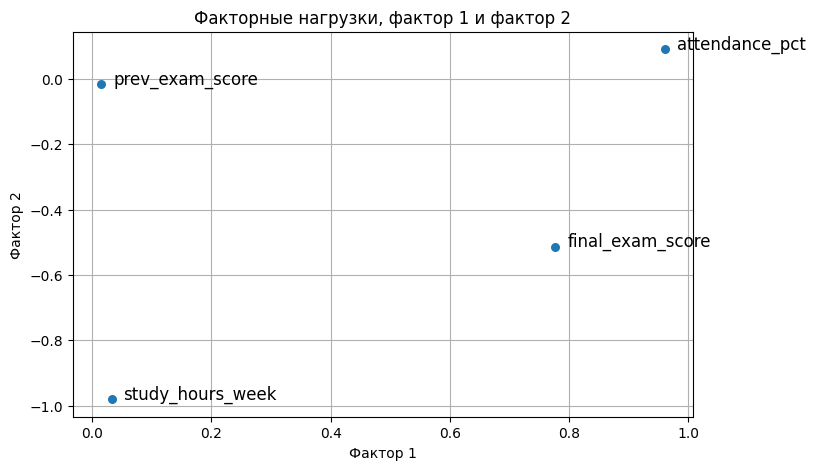

In [8]:
plt.figure(figsize=(8,5))
plt.scatter(rot_loadings["Фактор 1"], rot_loadings["Фактор 2"], marker='o', s=30)
plt.xlabel("Фактор 1")
plt.ylabel("Фактор 2")
for v in rot_loadings.index:
    x = rot_loadings.loc[v, "Фактор 1"]
    y = rot_loadings.loc[v, "Фактор 2"]
    plt.text(x + 0.02, y, v, fontsize=12)
plt.title("Факторные нагрузки, фактор 1 и фактор 2")
plt.grid(True)
plt.show()

На графике можно визуально отследить корреляцию переменных с факторами. Видно, например, что Часы учебы/нед и Процент посещения выступают как два независимых фактора, что подтверждается отсутствием между ними взаимосвязи.

Построим таблицу с коэффициентами линейных уравнений регрессий.

In [9]:
L = rot_loadings
A = L @ np.linalg.inv(L.T @ L)
A.columns = [f"Фактор {i+1}" for i in range(A.shape[1])]
display(A)

,Фактор 1,Фактор 2,Фактор 3
study_hours_week,-0.165187,-0.846629,0.067595
attendance_pct,0.691974,0.259782,0.083152
prev_exam_score,-0.033592,0.058012,-0.984133
final_exam_score,0.439260,-0.286785,-0.086596


Таким образом, процедура редукции данных позволила выделить только три значимых факторов. При этом удалось сократить число переменных с 4 до 3 с сохранением в данных более *94%* информации.